In [17]:
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sklearn.preprocessing import LabelEncoder
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sklearn.linear_model import RidgeClassifierCV, RidgeClassifier
from sklearn.metrics import classification_report, accuracy_score, log_loss
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc as pm
import aesara.tensor as at
import aesara

## 데이터

In [2]:
df = pd.read_csv("Et_H_CO.csv")
df.columns = ["time", "variable", "value", "label"]
df

,time,variable,value,label
0,1,X4,331,1
1,1,X5,273,1
2,1,X6,518,1
3,1,X7,572,1
4,1,X8,566,1
...,...,...,...,...
95035,2970,X7,707,4
95036,2970,X8,694,4
95037,2970,X9,872,4
95038,2970,X10,742,4


In [3]:
df["instance"] = df.groupby("label").ngroup()  # 0 ~ 3 (총 4개 시계열)
df

,time,variable,value,label,instance
0,1,X4,331,1,0
1,1,X5,273,1,0
2,1,X6,518,1,0
3,1,X7,572,1,0
4,1,X8,566,1,0
...,...,...,...,...,...
95035,2970,X7,707,4,3
95036,2970,X8,694,4,3
95037,2970,X9,872,4,3
95038,2970,X10,742,4,3


In [4]:
X = (
    df.groupby(["instance", "variable"])["value"]
    .apply(list)  # 시계열로 묶기
    .unstack()    # variable이 열로
    .applymap(pd.Series)
)
X

variable,X10,X11,X4,X5,X6,X7,X8,X9
instance,,,,,,,,
0,0 629 1 630 2 630 3 63...,0 719 1 719 2 719 3 71...,0 331 1 331 2 333 3 33...,0 273 1 274 2 273 3 27...,0 518 1 518 2 518 3 51...,0 572 1 571 2 571 3 57...,0 566 1 566 2 566 3 56...,0 700 1 700 2 701 3 70...
1,0 644 1 643 2 643 3 64...,0 737 1 736 2 736 3 73...,0 334 1 333 2 334 3 33...,0 272 1 272 2 272 3 27...,0 521 1 521 2 519 3 51...,0 548 1 548 2 547 3 54...,0 584 1 583 2 584 3 58...,0 727 1 727 2 728 3 72...
2,0 665 1 665 2 665 3 66...,0 759 1 759 2 759 3 75...,0 342 1 342 2 342 3 34...,0 275 1 275 2 275 3 27...,0 531 1 531 2 531 3 53...,0 598 1 598 2 598 3 59...,0 593 1 593 2 593 3 59...,0 739 1 739 2 739 3 73...
3,0 660 1 662 2 662 3 66...,0 754 1 754 2 755 3 75...,0 341 1 341 2 341 3 34...,0 279 1 279 2 279 3 27...,0 533 1 533 2 533 3 53...,0 627 1 626 2 627 3 62...,0 592 1 592 2 591 3 59...,0 735 1 735 2 734 3 73...


In [5]:
y = df.groupby("instance")["label"].first().values
y

array([1, 2, 3, 4])

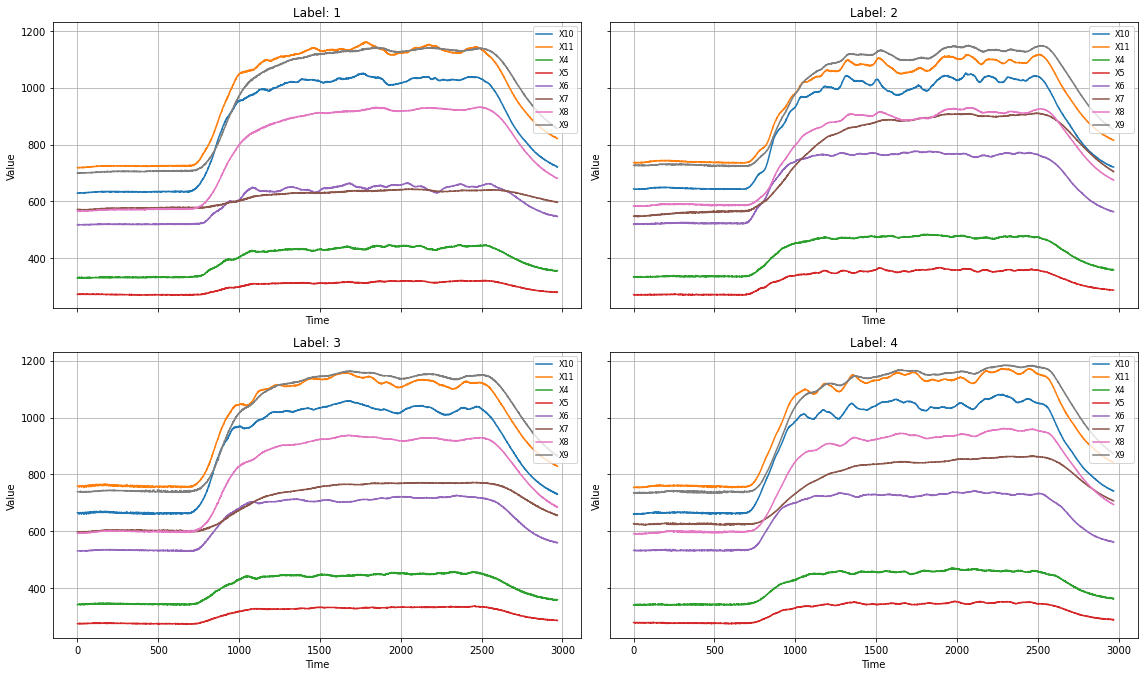

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10), sharex=True, sharey=True)
axes = axes.flatten()  # 2x2 → 1차원 배열로 변환

for i in range(len(X)):  # i: instance index (0~3)
    series = X.iloc[i]
    label = y[i]
    ax = axes[i]

    for var in series.index:
        ax.plot(series[var], label=var)

    ax.set_title(f"Label: {label}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)
    ax.legend(loc="upper right", fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## MiniROCKET + RidgeClassifierCV 학습

In [19]:
pipe = make_pipeline(
    MiniRocketMultivariate(),
    RidgeClassifierCV()
)
pipe.fit(X, y)

Pipeline(steps=[('minirocketmultivariate', MiniRocketMultivariate()),
                ('ridgeclassifiercv', RidgeClassifierCV())])

In [20]:
y_pred = pipe.predict(X)

In [21]:
acc = accuracy_score(y, y_pred)
cm = confusion_matrix(y, y_pred)

print("Training Accuracy:", acc)
print("Confusion Matrix:\n", cm)

Training Accuracy: 1.0
Confusion Matrix:
 [[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]


In [23]:
try:
    proba = pipe.decision_function(X)  # RidgeClassifier는 softmax 아님
    nlpp = log_loss(y, proba, labels=np.unique(y))
except:
    nlpp = "N/A (probability not available)"

# 정확도
acc = accuracy_score(y, y_pred)

# 리포트 출력
print(f"Test nlpp.: {nlpp:.3f}" if isinstance(nlpp, float) else f"Test nlpp.: {nlpp}")
print(f"Test acc.: {acc:.3f}")
print("Test classification report:\n")
print(classification_report(y, y_pred, digits=2))

Test nlpp.: 0.347
Test acc.: 1.000
Test classification report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



## MiniROCKET + LogisticRegression (no CV) 학습

In [10]:
pipe = make_pipeline(
    MiniRocketMultivariate(),
    RidgeClassifier(alpha=1.0)  # 고정된 alpha
)
pipe.fit(X, y)

Pipeline(steps=[('minirocketmultivariate', MiniRocketMultivariate()),
                ('ridgeclassifier', RidgeClassifier())])

In [11]:
y_pred = pipe.predict(X)

In [12]:
acc = accuracy_score(y, y_pred)
cm = confusion_matrix(y, y_pred)

print("Training Accuracy:", acc)
print("Confusion Matrix:\n", cm)

Training Accuracy: 1.0
Confusion Matrix:
 [[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
